# Measure GRACE performance on identified objects:

### All metrics here are **exact**, i.e measure similarity between two graphs formed of identical node count which have the same positions. The only thing that differs between the graphs is the edges and object membership / individual identities. 

*Note:* The rationale behind evaluating the per-node and per-edge metrics at this stage is that the optimisation step can (and most likely will) change the identities of the individual nodes / edges when looking for a globally optimal solution. For example, a single node be predicted (by the GCN / classification method of choice) to have a high probability of being considered a real node (true positive, TP), but if such node is surrounded by no other plausible nodes or forms no acceptable edges, it has a high likelihood to be considered a fake node (true negative, TN) in favour of the global optimisation. This is why evaluation of the node- & edge-specific metrics is vital to observe the changes made to the graph components as a result of the optimisation step.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.metrics import (
    confusion_matrix, 
    precision_recall_fscore_support,
    jaccard_score,
)


In [9]:
from grace.base import GraphAttrs
from grace.models.optimiser import optimise_graph

from grace.io.image_dataset import ImageGraphDataset, generate_ground_truth_graph

from grace.simulator.simulate_graph import (
    random_graph, 
    update_graph_with_dummy_predictions, 
    imply_annotations_from_dummy_predictions
)

from grace.evaluation.visualisation import (
    plot_simple_graph,
    plot_connected_components,
    display_image_and_grace_annotation,
)


### Generate a random graph, update dummy labels & generate GT graph:

In [3]:
G = random_graph(n_motifs=5, density=0.05)
node_conf, edge_conf = 0.5, 0.1
update_graph_with_dummy_predictions(
    G, 
    node_confidence=node_conf, 
    edge_confidence=edge_conf
)
imply_annotations_from_dummy_predictions(G)

In [4]:
true_graph = generate_ground_truth_graph(G)
true_graph

In [5]:
# node_conf, edge_conf = 0.5, 0.3
# update_graph_with_dummy_predictions(
#     G, 
#     node_confidence=node_conf, 
#     edge_confidence=edge_conf
# )
pred_graph = optimise_graph(G)
pred_graph

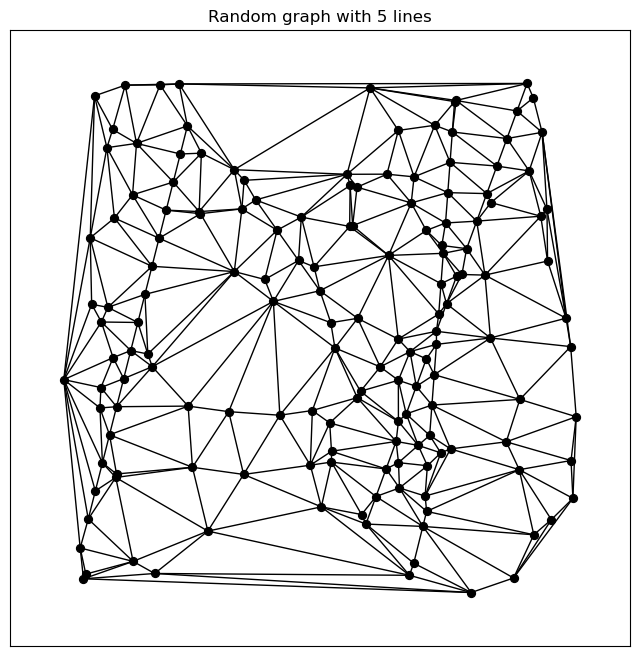

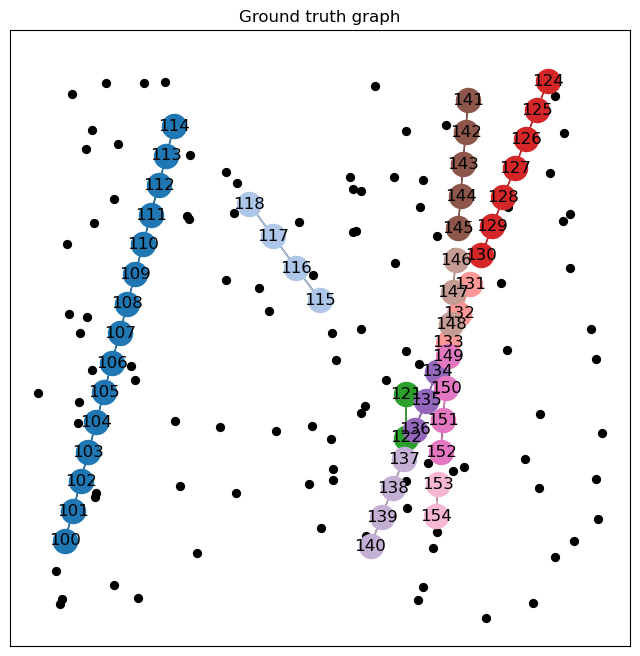

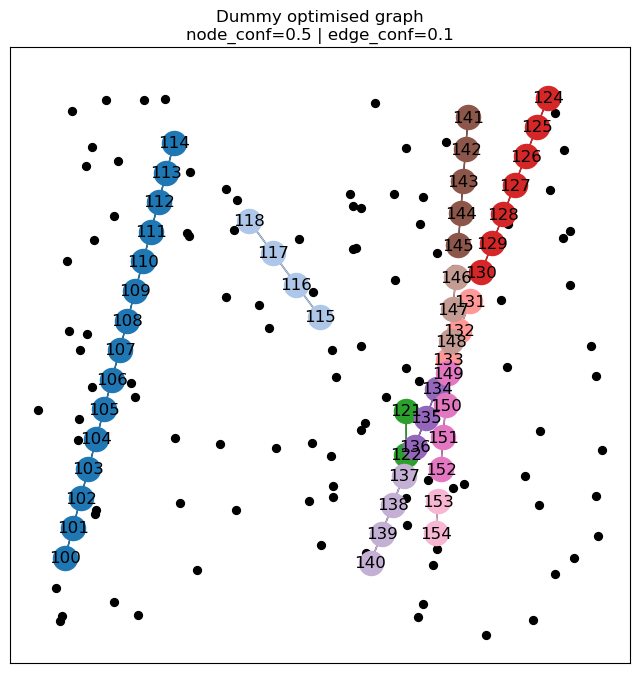

In [6]:
figsize = (8, 8)
plot_simple_graph(G, figsize=figsize, title="Random graph with 5 lines")
plot_connected_components(true_graph, figsize=figsize, title=f"Ground truth graph")
plot_connected_components(pred_graph, figsize=figsize, title=f"Dummy optimised graph\nnode_conf={node_conf} | edge_conf={edge_conf}")


### Perform checks:

In [7]:
assert pred_graph.number_of_nodes() == true_graph.number_of_nodes()
assert pred_graph.number_of_edges() == true_graph.number_of_edges()


### Create an image annotation automatically:

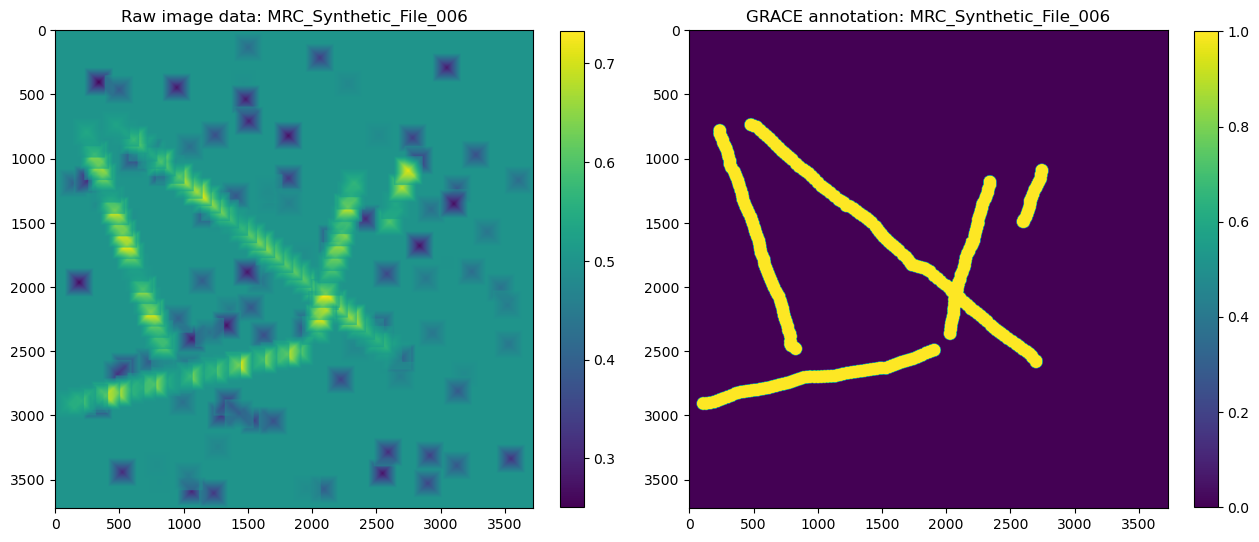

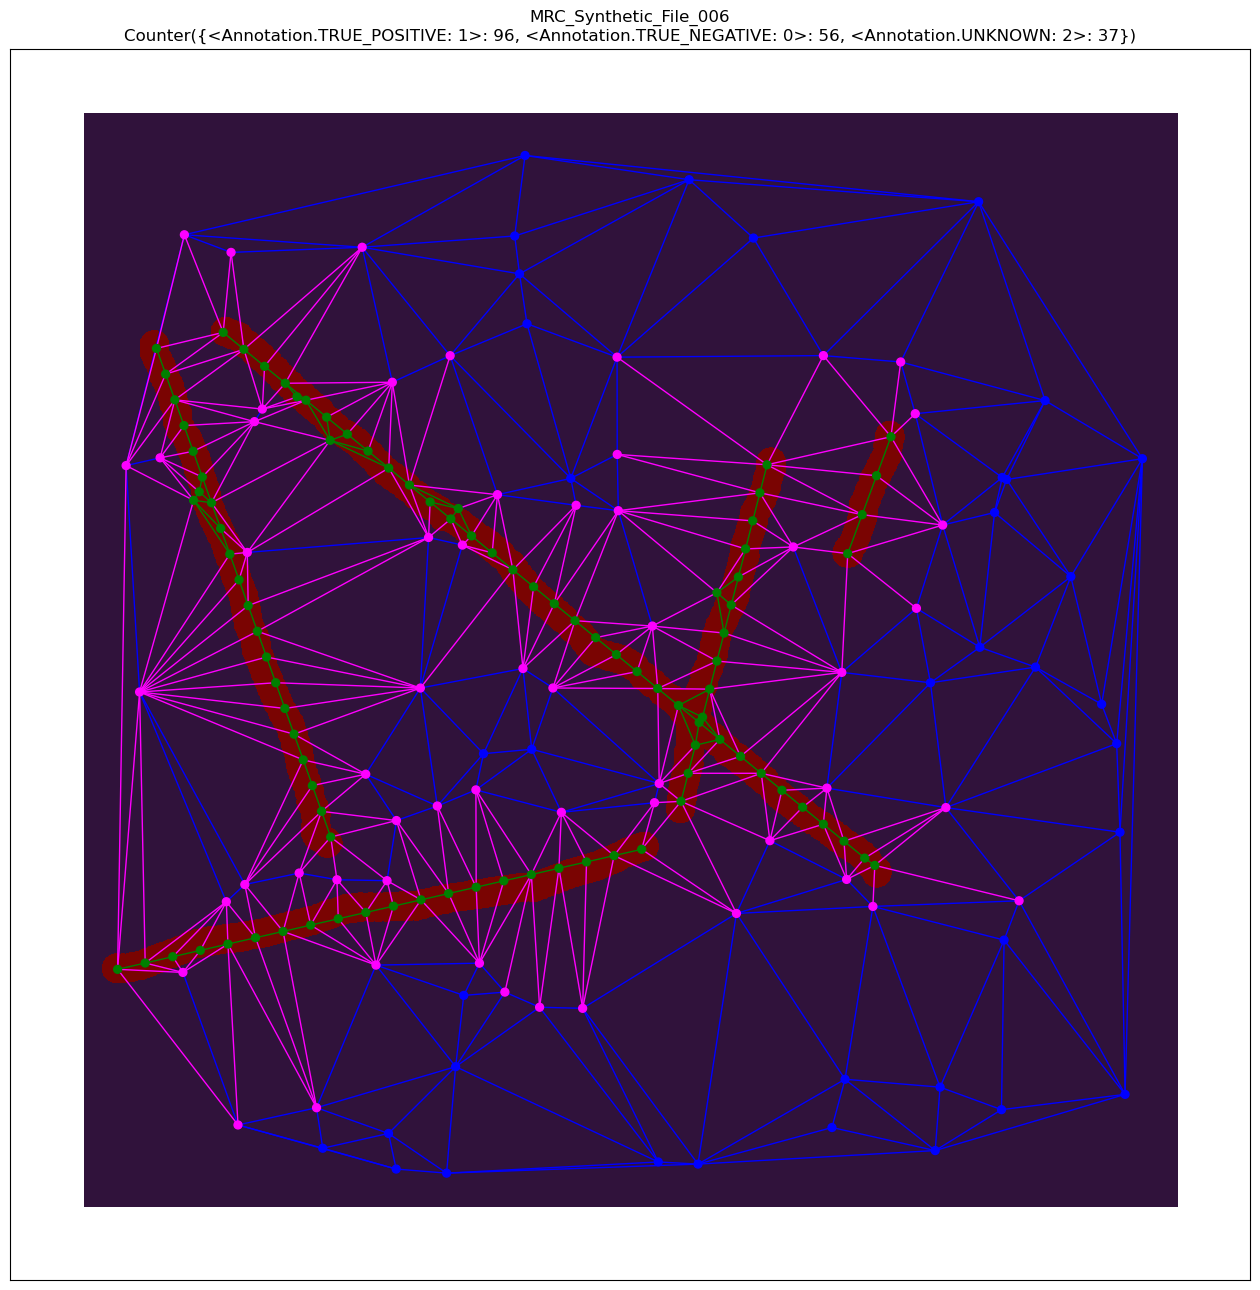

In [10]:
grace_path = "/Users/kulicna/Desktop/dataset/shape_stars/infer"
dataset = ImageGraphDataset(image_dir=grace_path, grace_dir=grace_path)
image, graph_data = dataset[0]
graph = graph_data["graph"]
gt_graph = generate_ground_truth_graph(graph)
display_image_and_grace_annotation(image=image, target=graph_data)

### Unpack:

In [11]:
graph

(3724, 3724)


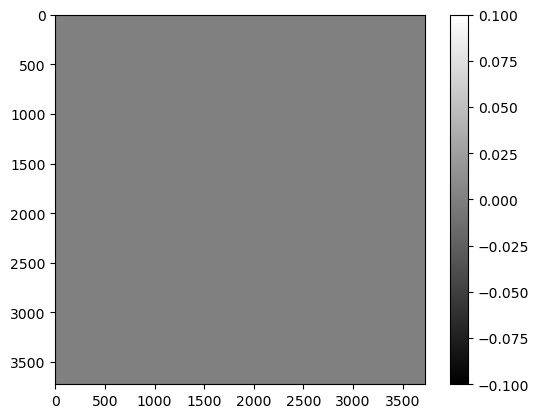

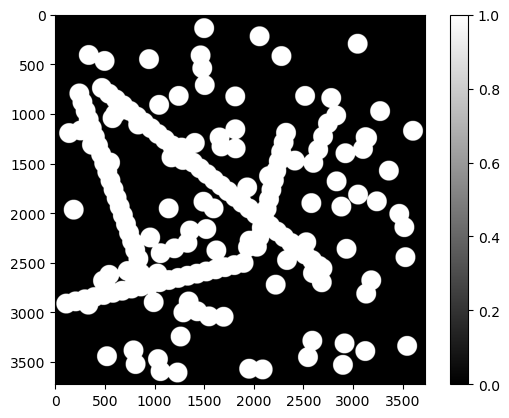

In [35]:
import cv2

# Load your image and graph, and identify connected components
image = graph_data["annotation"]
print (image.shape)
# graph = graph
connected_components = {i: cc for i, cc in enumerate(nx.connected_components(graph))}

# Create an annotation mask with the same dimensions as the image
annotation_mask = np.zeros_like(image, dtype=np.uint8)

# Display or save the annotation mask
plt.imshow(annotation_mask, cmap='gray')
plt.colorbar()
plt.show()

# Define brush size (approx. 5 pixels)
brush_size = 100

# Draw connected components on the annotation mask
for component_label, component_nodes in connected_components.items():
    for node in component_nodes:
        # Get the coordinates of the node
        node_x = int(graph.nodes[node][GraphAttrs.NODE_X])
        node_y = int(graph.nodes[node][GraphAttrs.NODE_Y])

        # Create a circle mask centered at the node coordinates
        y, x = np.ogrid[-brush_size:brush_size+1, -brush_size:brush_size+1]
        circle_mask = x**2 + y**2 <= brush_size**2
        # circle_mask = circle_mask[1:-1, 1:-1]

        # Display or save the annotation mask
        # plt.imshow(circle_mask, cmap='gray')
        # plt.colorbar()
        # plt.show()

        # Calculate the bounding box for the circle
        x_start = max(0, node_x - brush_size)
        x_end = min(annotation_mask.shape[1], node_x + brush_size + 1)
        y_start = max(0, node_y - brush_size)
        y_end = min(annotation_mask.shape[0], node_y + brush_size + 1)

        # Apply the circle mask to the annotation mask
        # annotation_mask[y_start:y_end, x_start:x_end] = np.maximum(annotation_mask[y_start:y_end, x_start:x_end], circle_mask)
        annotation_mask[y_start:y_end, x_start:x_end] |= circle_mask

        # break

# Display or save the annotation mask
plt.imshow(annotation_mask, cmap='gray')
plt.colorbar()
plt.show()

In [52]:
def draw_annotation_mask_from_ground_truth_graph(gt_graph: nx.Graph, shape: tuple[int, int], line_thickness: int = 50):
    """TODO: Fill in.
    
    Parameters
    ----------
    G : nx.Graph
        The ground truth graph.
    """

    # Load your image and graph, and identify connected components
    # image = graph_data["annotation"]
    # graph = gt_graph

    # Create an annotation mask with the same dimensions as the image
    annotation_mask = np.zeros(shape=shape, dtype=np.uint8)

    # 
    for edge in gt_graph.edges():
        node1_x, node1_y = int(gt_graph.nodes[edge[0]][GraphAttrs.NODE_X]), int(gt_graph.nodes[edge[0]][GraphAttrs.NODE_Y])
        node2_x, node2_y = int(gt_graph.nodes[edge[1]][GraphAttrs.NODE_X]), int(gt_graph.nodes[edge[1]][GraphAttrs.NODE_Y])
        
        # Calculate the direction vector of the edge
        # direction_vector = np.array([node2_x - node1_x, node2_y - node1_y])
        # normalized_direction = direction_vector / np.linalg.norm(direction_vector)
        
        # Calculate the orthogonal vector for line thickness
        # orthogonal_vector = np.array([-normalized_direction[1], normalized_direction[0]])
        
        # Calculate the points for the line endpoints
        endpoint1 = np.array([node1_x, node1_y])
        endpoint2 = np.array([node2_x, node2_y])
        
        # Calculate the line points using integer coordinates
        num_points = int(np.linalg.norm(endpoint2 - endpoint1))
        line_points = np.column_stack((np.linspace(endpoint1[0], endpoint2[0], num_points),
                                    np.linspace(endpoint1[1], endpoint2[1], num_points)))

        # Set the line points in the annotation mask
        for point in line_points:
            y, x = map(int, point)
            y_start = max(0, y - line_thickness // 2)
            y_end = min(annotation_mask.shape[0], y + line_thickness // 2 + 1)
            x_start = max(0, x - line_thickness // 2)
            x_end = min(annotation_mask.shape[1], x + line_thickness // 2 + 1)
            annotation_mask[y_start:y_end, x_start:x_end] = 1

    annotation_mask = annotation_mask.T
    return annotation_mask



In [54]:
annotation_mask = draw_annotation_mask_from_ground_truth_graph(gt_graph, shape=image.shape)

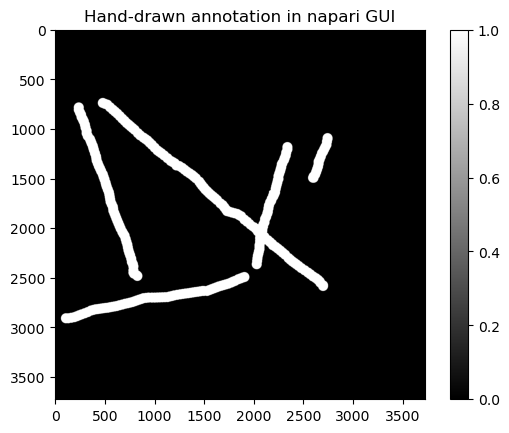

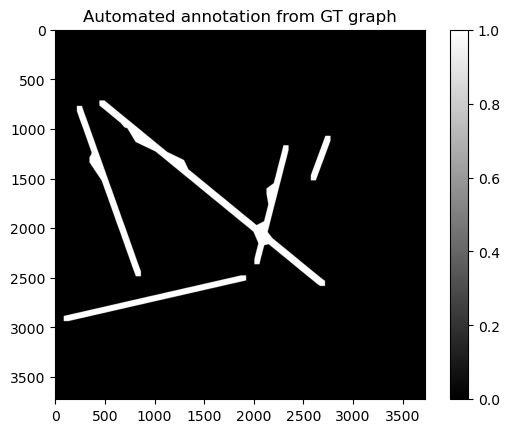

In [55]:
# Display or save the annotation mask
plt.imshow(image, cmap='gray')
plt.title("Hand-drawn annotation in napari GUI")
plt.colorbar()
plt.show()

# Display or save the annotation mask
plt.imshow(annotation_mask, cmap='gray')
plt.title("Automated annotation from GT graph")
plt.colorbar()
plt.show()

# TODO: 
* simple IoU between objects
* localisation precision - mean squared displacement between centroids

*Note:* Evaluating the agreement between two resulting images (annotation masks) can involve several metrics to assess different aspects of the agreement. Here are a few metrics you can consider:

Intersection over Union (IoU):

As you mentioned, IoU measures the overlap between two annotation masks. It's defined as the ratio of the intersection of the two masks to their union. You can calculate IoU for each pair of objects that overlap and then compute the mean IoU across all pairs.
Mean Squared Displacement (MSD):

MSD measures the average squared distance between corresponding pixels in two annotation masks. It's a measure of how far the pixels have moved between the two masks. You can calculate the squared Euclidean distance between corresponding pixels and compute the mean across all pairs.
Pixel Accuracy:

Pixel accuracy measures the percentage of correctly labeled pixels in the annotation masks. You compare each pixel in one mask with the corresponding pixel in the other mask and calculate the percentage of pixels that match.
F1 Score:

F1 score combines precision and recall to provide a balanced measure of agreement. You would treat the pixels in one mask as positives and the pixels in the other mask as predicted positives. Then, you calculate precision, recall, and F1 score based on these two sets of pixels.
Dice Coefficient:

The Dice coefficient is another metric commonly used for measuring overlap or agreement between binary images. It's defined as twice the intersection divided by the sum of the sizes of the two masks.
Hausdorff Distance:

Hausdorff distance measures the maximum distance between the pixels in one mask and the closest pixel in the other mask. It captures the maximum displacement between corresponding pixels.
Visual Inspection:

While quantitative metrics are valuable, visual inspection of the resulting images is also crucial. You can overlay the two annotation masks on the original image and visually assess their alignment.
Consistency of Connected Components:

If the annotation masks are expected to form connected components, you can measure the agreement in terms of whether the connected components match between the two masks.
Cluster Matching Metrics:

If your objects can be thought of as clusters or groups of pixels, you can explore metrics designed for clustering, such as adjusted Rand index or normalized mutual information.
Object Detection Metrics:

Depending on the application, you might consider using object detection evaluation metrics such as average precision (AP) if your annotation masks represent object instances.
When comparing two annotation masks, keep in mind the specific characteristics of your data and the goals of your analysis. Depending on the complexity of the images and the nature of the objects you're analyzing, certain metrics may be more appropriate than others. It's also a good idea to use a combination of metrics to get a comprehensive understanding of the agreement between the annotation masks.